# **Keyword Ekstraction**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/PPW/tugas

/content/drive/MyDrive/PPW/tugas


In [4]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


In [24]:
# Mengimpor modul yang diperlukan
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.corpus import stopwords

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### **Load Data**

In [6]:
# Path ke file di Google Drive (ubah sesuai lokasimu)
file_path = '/content/drive/MyDrive/PPW/tugas/Tugas-Crawling-Data-Berita-2-kategori.csv'

# Baca file CSV
df = pd.read_csv(file_path)

### **Ekstraksi Kalimat**

In [71]:
text = df['Isi Berita'][0]

# Ekstraksi kalimat
sentences = sent_tokenize(text)

# Membuat DataFrame dari kalimat
df_sentences = pd.DataFrame(sentences, columns=["Kalimat"])
df_sentences.head()

,Kalimat
0,"TIMESINDONESIA, JAKARTA – Di bawah kepemimpina..."
1,Hal itu dengan fokus pada kemandirian pangan d...
2,Prabowo diharapkan mampu membawa Indonesia men...
3,ketika dimintai pendapatnya terkait prospek pe...
4,Setelah dilantik sebagai Presiden Republik Ind...


### **Preprosesing**

In [12]:
# Membuat objek stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Mendapatkan daftar stopwords bahasa Indonesia
stop_words = set(stopwords.words('indonesian'))

def preprocess_sentence(sentence):
    # Hanya menyisakan huruf dan titik, serta menghapus spasi yang berlebihan
    sentence_cleaned = re.sub(r'[^a-zA-Z\s.]', ' ', sentence).strip()  # Menghapus karakter selain huruf dan titik
    sentence_cleaned = re.sub(r'\s+', ' ', sentence_cleaned)  # Menghapus spasi lebih dari satu
    sentence_cleaned = sentence_cleaned.lower()  # Ubah ke huruf kecil

    # Tokenisasi
    words = word_tokenize(sentence_cleaned)  # Memecah teks menjadi kata-kata

    # Stemming setiap kata
    stemmed_words = [stemmer.stem(word) for word in words]

    # Menghapus stopwords dan kata kosong (jika ada spasi kosong yang tersisa)
    words_without_stopwords = [word for word in stemmed_words if word not in stop_words and word.strip() != '']

    return words_without_stopwords

# Preprocessing kalimat menjadi daftar kata
preprocessed_words = [word for sentence in sentences for word in preprocess_sentence(sentence)]

# Membuat DataFrame dari kata-kata yang sudah dipreproses
df_preprocessed = pd.DataFrame(preprocessed_words, columns=["kata_clean"])

# Menghapus baris kosong jika ada (jika secara tidak sengaja spasi masih tersisa)
df_preprocessed = df_preprocessed[df_preprocessed['kata_clean'].str.strip() != '']

#### Hasil Preprosesing menjadi daftar kata

In [19]:
df_preprocessed

,kata_clean
0,timesindonesia
1,jakarta
2,pimpin
3,presiden
4,ri
...,...
549,news
550,klik
551,link
552,lupa


### **TF-IDF**

- tf-idf hanya mempertahankan kata-kata yang memiliki makna penting berdasarkan frekuensi kemunculannya dalam dokumen

- hanya sekitar 305 kata yang dipertahankan oleh TF-IDF karena kata-kata ini dianggap penting (berdasarkan bobotnya).

- Kata-kata yang dicetak oleh TF-IDF, yaitu 305 kata, merupakan kata-kata yang dianggap lebih relevan atau penting dalam teks berdasarkan frekuensi kemunculan mereka di seluruh dokumen yang sedang dianalisis. Kata-kata yang tidak dipertahankan bisa jadi terlalu umum dan tidak memberikan informasi tambahan tentang dokumen.


In [40]:
# Inisialisasi TfidfVectorizer tanpa batasan jumlah fitur
vectorizer = TfidfVectorizer()

# Mengonversi kata yang sudah dipreproses menjadi string untuk keperluan TF-IDF
preprocessed_text = [' '.join(preprocessed_words)]

# Fit dan transform teks ke dalam TF-IDF
tfidf_matrix = vectorizer.fit_transform(preprocessed_text)

# Konversi TF-IDF matrix ke DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

tfidf_df

,acara,acu,adil,adu,advertisement,agenda,ajak,akses,aktif,akuntabel,...,umkm,unggul,uni,upaya,usaha,utama,visi,waris,wibawa,wujud
0,0.018131,0.036262,0.018131,0.018131,0.018131,0.018131,0.018131,0.018131,0.018131,0.018131,...,0.018131,0.018131,0.018131,0.036262,0.036262,0.054393,0.036262,0.018131,0.018131,0.036262


#### mencetak 10 kata dengan bobot tfidf paling tinggi

In [42]:
# Mengekstraksi kata-kata dengan bobot tertinggi
top_n = 10  # Jumlah kata tertinggi yang ingin diekstraksi
tfidf_top_words = tfidf_df.T.sort_values(by=0, ascending=False).head(top_n)

tfidf_top_words

,0
prabowo,0.562059
muhlis,0.344488
indonesia,0.344488
perintah,0.217571
demokrasi,0.217571
kuat,0.145048
ali,0.145048
rakyat,0.126917
energi,0.108786
jaga,0.090655


### **Cosinus Similarity**

In [58]:
# Menghitung cosine similarity antar kata berdasarkan TF-IDF dari kata-kata teratas
cosine_sim_matrix = cosine_similarity(tfidf_df[tfidf_top_words.index].T)

# Mengubah cosine similarity matrix ke dalam DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim_matrix,
                             index=tfidf_top_words.index,
                             columns=tfidf_top_words.index)

cosine_sim_df

,prabowo,muhlis,indonesia,perintah,demokrasi,kuat,ali,rakyat,energi,jaga
prabowo,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
muhlis,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
indonesia,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
perintah,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
demokrasi,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
kuat,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ali,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
rakyat,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
energi,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
jaga,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### **Matriks Adjacency**

In [47]:
# Threshold untuk adjacency (misalnya > 0.8 dianggap connected)
threshold = 0.8
adj_matrix_cosine = (cosine_sim_matrix > threshold).astype(int)
np.fill_diagonal(adj_matrix_cosine, 0)  # Menghapus self-loops

# Mengonversi adjacency matrix menjadi DataFrame
adjacency_df = pd.DataFrame(adj_matrix_cosine,
                            index=tfidf_top_words.index,
                            columns=tfidf_top_words.index)

adjacency_df

,prabowo,muhlis,indonesia,perintah,demokrasi,kuat,ali,rakyat,energi,jaga
prabowo,0,1,1,1,1,1,1,1,1,1
muhlis,1,0,1,1,1,1,1,1,1,1
indonesia,1,1,0,1,1,1,1,1,1,1
perintah,1,1,1,0,1,1,1,1,1,1
demokrasi,1,1,1,1,0,1,1,1,1,1
kuat,1,1,1,1,1,0,1,1,1,1
ali,1,1,1,1,1,1,0,1,1,1
rakyat,1,1,1,1,1,1,1,0,1,1
energi,1,1,1,1,1,1,1,1,0,1
jaga,1,1,1,1,1,1,1,1,1,0


### **Graph**

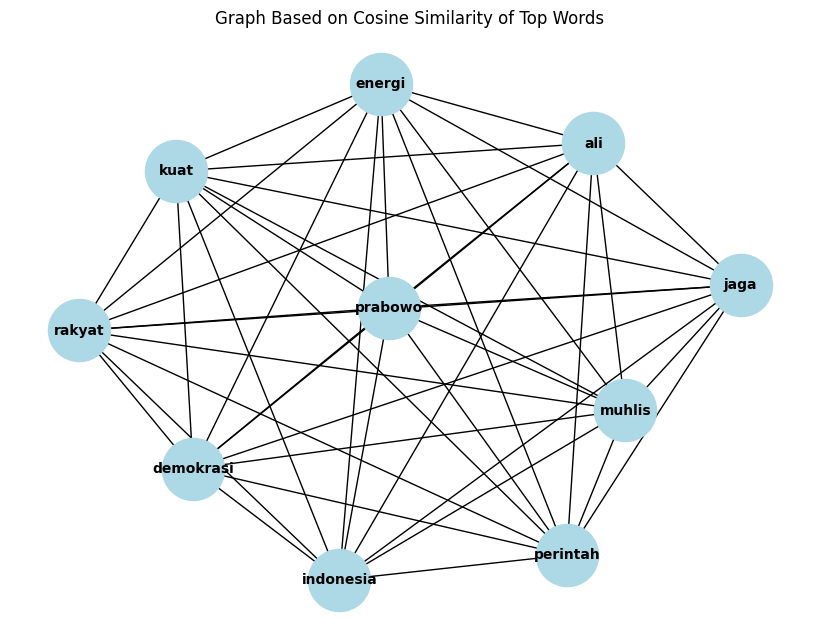

In [46]:
# Membuat graph dari adjacency matrix berdasarkan cosine similarity
graph_cosine = nx.from_numpy_array(adj_matrix_cosine)

# Membuat label kata dari tfidf_top_words
labels = {i: word for i, word in enumerate(tfidf_top_words.index)}

# Menggambar graph cosine similarity dengan label kata
plt.figure(figsize=(8, 6))
pos_cosine = nx.spring_layout(graph_cosine)  # Layout untuk menampilkan graph
nx.draw(graph_cosine, pos_cosine, with_labels=True, labels=labels, node_color="lightblue", node_size=2000, font_size=10, font_weight='bold')
plt.title("Graph Based on Cosine Similarity of Top Words")
plt.show()

### **Centrality**

In [74]:
# Menghitung centrality
degree_centrality = nx.degree_centrality(graph_cosine)

# Membuat dataframe untuk setiap centrality
centrality_df = pd.DataFrame({
    'Word': [labels[i] for i in degree_centrality.keys()],
    'Degree Centrality': degree_centrality.values()
})

# Menampilkan dataframe
centrality_df

,Word,Degree Centrality
0,prabowo,1.0
1,muhlis,1.0
2,indonesia,1.0
3,perintah,1.0
4,demokrasi,1.0
5,kuat,1.0
6,ali,1.0
7,rakyat,1.0
8,energi,1.0
9,jaga,1.0


### **Keyword**

In [75]:
word = centrality_df['Word'].iloc[0]  # Mengambil kata pertama
degree_centrality = centrality_df['Degree Centrality'].iloc[0]  # Mengambil Degree Centrality pertama

print(f"Kata Kunci: {word} dengan degree centrality {degree_centrality}")


Kata Kunci: prabowo dengan degree centrality 1.0
